In [ ]:
# !pip install wordcloud
# Can apply K Mediods as well 

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud, STOPWORDS

In [2]:
with open("StopWords.txt") as f:
    stop_words = f.read()

stop_words = stop_words.split("\n")
stop_words_dict = {}
for stop_word in stop_words:
    stop_words_dict[stop_word] = 1

In [3]:
utterances_data = pd.read_csv("utterance_data.csv")

In [4]:
utterances_data

,utterance
0,i need $20000 transferred from my savings to m...
1,complete a transaction from savings to checkin...
2,transfer $20000 from my savings account to che...
3,take $20000 from savings and put it in checking
4,put $20000 into my checking account from my sa...
...,...
2245,give weather update now
2246,want to know the weather
2247,tell me the weather for today
2248,what is the current weather like


# 1. Spacy medium language model

In [5]:
spacy_medium_model = spacy.load("en_core_web_md")

### a. No Pre-processing

In [6]:
utterance_vector_list = []

for index, row in utterances_data.iterrows():
    utterance_vector = spacy_medium_model(row["utterance"]).vector
    utterance_vector_list.append(utterance_vector)

In [7]:
spacy_medium_utterance_vector_df = pd.DataFrame(utterance_vector_list)

In [8]:
spacy_medium_utterance_vector_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.001753,0.107017,-0.210697,0.003662,0.112849,0.066423,-0.158899,-0.194024,0.087309,1.771004,...,-0.256982,0.124196,0.165505,-0.032713,0.024160,-0.096031,-0.002968,0.040832,-0.083608,0.061440
1,-0.084327,0.061756,-0.127338,0.063442,0.106728,-0.027005,-0.157229,-0.117242,0.154974,1.680684,...,-0.364703,0.180406,0.159856,-0.069793,-0.058976,-0.079016,-0.172501,0.001837,-0.022798,0.059054
2,-0.098790,0.142810,-0.222515,0.062024,0.010343,0.068913,-0.171063,-0.150005,0.043434,1.766824,...,-0.392482,0.222063,0.281317,-0.028730,0.064711,-0.167903,-0.051145,0.071738,-0.088382,0.006392
3,-0.116451,0.138277,-0.072469,-0.027072,0.119356,0.001433,-0.230465,-0.110207,0.102530,1.944694,...,-0.330693,0.063794,0.196954,-0.115161,-0.112778,-0.059871,-0.102383,-0.014173,-0.007933,0.041396
4,-0.080748,0.132806,-0.217252,0.116663,0.087127,0.071578,-0.235346,-0.146140,0.061761,1.886904,...,-0.379858,0.156581,0.306510,0.005401,-0.038637,-0.145397,-0.008250,0.045944,-0.103920,-0.063432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,-0.113771,0.173270,-0.141332,-0.118344,-0.102967,-0.099597,0.155304,-0.242512,-0.087302,2.131250,...,-0.310955,0.188608,-0.047555,-0.093398,0.189595,-0.338406,-0.331312,-0.106147,-0.112004,0.060834
2246,0.129389,0.179358,-0.236456,-0.013042,0.038800,0.028361,0.038872,0.107254,-0.050246,2.434420,...,-0.214001,0.210640,-0.079368,-0.171908,0.134174,-0.215216,-0.246844,0.017182,0.138357,0.145429
2247,-0.051182,0.282077,-0.256207,-0.020200,0.093289,-0.132514,0.079985,-0.013077,-0.085716,2.433050,...,-0.255987,-0.036358,0.101168,-0.130347,0.121947,-0.234553,-0.062716,0.047022,-0.071197,0.116277
2248,0.041140,0.230624,-0.041323,-0.056232,0.039635,0.065667,0.013528,0.030725,-0.011634,2.419017,...,-0.127216,0.201910,-0.000709,-0.154989,0.098442,0.002269,-0.236802,-0.089033,-0.004892,0.087839


In [9]:
# defining a common function to be used which computes the word cloud object

def create_word_cloud(cluster_number, cluster_indices_dict, utterance_data):
    word_cloud_string = ""
    indices = cluster_indices_dict[cluster_number]
    word_cloud_string = " ".join(utterances_data.iloc[cluster_indices_dict[cluster_number]]["utterance"])
    wordcloud = WordCloud(
        width = 800, height = 800, background_color ='white', min_font_size = 10, max_words=10
    ).generate(word_cloud_string)
    
    return wordcloud


### 5 clusters

In [10]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.2005525637819351


In [21]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(20,20))

# ax_list = [ax1, ax2, ax3]
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax2[0].set_title("Cluster 3")
# ax2[1].set_title("Cluster 4")
# ax3[0].set_title("Cluster 5")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax2[0].imshow(wordcloud_list[2])
# ax2[1].imshow(wordcloud_list[3])
# ax3[0].imshow(wordcloud_list[4])

### 10 clusters

In [14]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters, random_state=4)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.21400000526735297


In [24]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize=(10 ,30))
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax2[0].set_title("Cluster 3")
# ax2[1].set_title("Cluster 4")
# ax3[0].set_title("Cluster 5")
# ax3[1].set_title("Cluster 6")
# ax4[0].set_title("Cluster 7")
# ax4[1].set_title("Cluster 8")
# ax5[0].set_title("Cluster 9")
# ax5[1].set_title("Cluster 10")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax2[0].imshow(wordcloud_list[2])
# ax2[1].imshow(wordcloud_list[3])
# ax3[0].imshow(wordcloud_list[4])
# ax3[1].imshow(wordcloud_list[5])
# ax4[0].imshow(wordcloud_list[6])
# ax4[1].imshow(wordcloud_list[7])
# ax5[0].imshow(wordcloud_list[8])
# ax5[1].imshow(wordcloud_list[9])

### 15 clusters

In [38]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters, random_state=2)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.25635968525946834


In [25]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 3, figsize=(20 ,30))
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax1[2].set_title("Cluster 3")
# ax2[0].set_title("Cluster 4")
# ax2[1].set_title("Cluster 5")
# ax2[2].set_title("Cluster 6")
# ax3[0].set_title("Cluster 7")
# ax3[1].set_title("Cluster 8")
# ax3[2].set_title("Cluster 9")
# ax4[0].set_title("Cluster 10")
# ax4[1].set_title("Cluster 11")
# ax4[2].set_title("Cluster 12")
# ax5[0].set_title("Cluster 13")
# ax3[1].set_title("Cluster 14")
# ax5[2].set_title("Cluster 15")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax1[2].imshow(wordcloud_list[2])
# ax2[0].imshow(wordcloud_list[3])
# ax2[1].imshow(wordcloud_list[4])
# ax2[2].imshow(wordcloud_list[5])
# ax3[0].imshow(wordcloud_list[6])
# ax3[1].imshow(wordcloud_list[7])
# ax3[2].imshow(wordcloud_list[8])
# ax4[0].imshow(wordcloud_list[9])
# ax4[1].imshow(wordcloud_list[10])
# ax4[2].imshow(wordcloud_list[11])
# ax5[0].imshow(wordcloud_list[12])
# ax5[1].imshow(wordcloud_list[13])
# ax5[2].imshow(wordcloud_list[14])

### b. Remove Stop Words

In [6]:
def _remove_stop_words_from_sentence(sentence):
    tokens = sentence.split()
    new_tokens = []
    
    for token in tokens:
        if token in stop_words_dict:
            continue
        else:
            new_tokens.append(token)
            
    return " ".join(new_tokens)

In [7]:
utterance_vector_list = []

for index, row in utterances_data.iterrows():
    updated_sentence = _remove_stop_words_from_sentence(row["utterance"])
    utterance_vector = spacy_medium_model(updated_sentence).vector
    utterance_vector_list.append(utterance_vector)

In [8]:
spacy_medium_utterance_vector_df = pd.DataFrame(utterance_vector_list)

# remove all the nan values from the df
spacy_medium_utterance_vector_df = spacy_medium_utterance_vector_df.dropna(how="all")

spacy_medium_utterance_vector_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.166550,0.065292,-0.051818,-0.148702,0.037537,0.115025,-0.364436,-0.256130,0.176856,1.274208,...,-0.354636,0.158433,0.234047,-0.067820,-0.099314,-0.073145,-0.120800,0.001177,-0.071930,-0.067200
1,-0.213308,0.060453,-0.101811,-0.023651,0.095062,0.026731,-0.269532,-0.159725,0.251382,1.215907,...,-0.459947,0.199163,0.155457,-0.035805,-0.009125,-0.160529,-0.210962,0.009256,0.086173,-0.006292
2,-0.200993,0.181571,-0.189186,-0.055294,-0.078657,0.096959,-0.205163,-0.199027,0.070272,1.511063,...,-0.468651,0.246554,0.280161,-0.095903,0.117079,-0.184902,-0.108827,0.044508,-0.037939,-0.055020
3,-0.237216,0.134752,-0.074626,-0.134840,0.085429,0.025669,-0.320750,-0.206586,0.161484,1.293028,...,-0.385588,0.121838,0.266946,-0.115733,-0.130890,-0.102921,-0.106082,-0.035832,0.045860,-0.115438
4,-0.232737,0.196948,-0.177941,-0.025868,-0.069079,0.042482,-0.256225,-0.174937,0.076457,1.624163,...,-0.459066,0.212690,0.261630,-0.076904,0.032330,-0.216443,-0.102391,-0.034885,-0.007206,-0.143815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,-0.034511,0.142406,-0.076045,-0.169038,-0.347430,0.195750,0.255785,-0.156305,-0.098385,1.718950,...,-0.352385,0.465705,-0.064376,-0.060780,0.363360,-0.476825,-0.501345,0.000425,-0.210417,0.073737
2246,-0.004789,0.374390,-0.207165,-0.206445,-0.019480,0.186485,0.182125,0.159710,-0.198281,2.378900,...,-0.244710,0.272275,-0.250735,-0.160248,0.331720,-0.322605,-0.424230,0.058473,0.212533,0.051537
2247,-0.084311,0.417737,-0.173832,-0.105170,0.021784,-0.120931,0.073115,0.013163,-0.168329,2.483167,...,-0.275337,0.040247,-0.039220,-0.137000,0.168200,-0.376473,-0.204331,0.026930,0.062849,0.056905
2248,0.141238,0.173069,0.263020,0.102215,-0.190480,0.095840,0.000140,0.183595,-0.033345,2.199250,...,-0.147990,0.458210,0.011245,-0.214987,0.206380,-0.204490,-0.365450,-0.164570,-0.100182,-0.094973


In [9]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters, random_state=180)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.23072163016407476


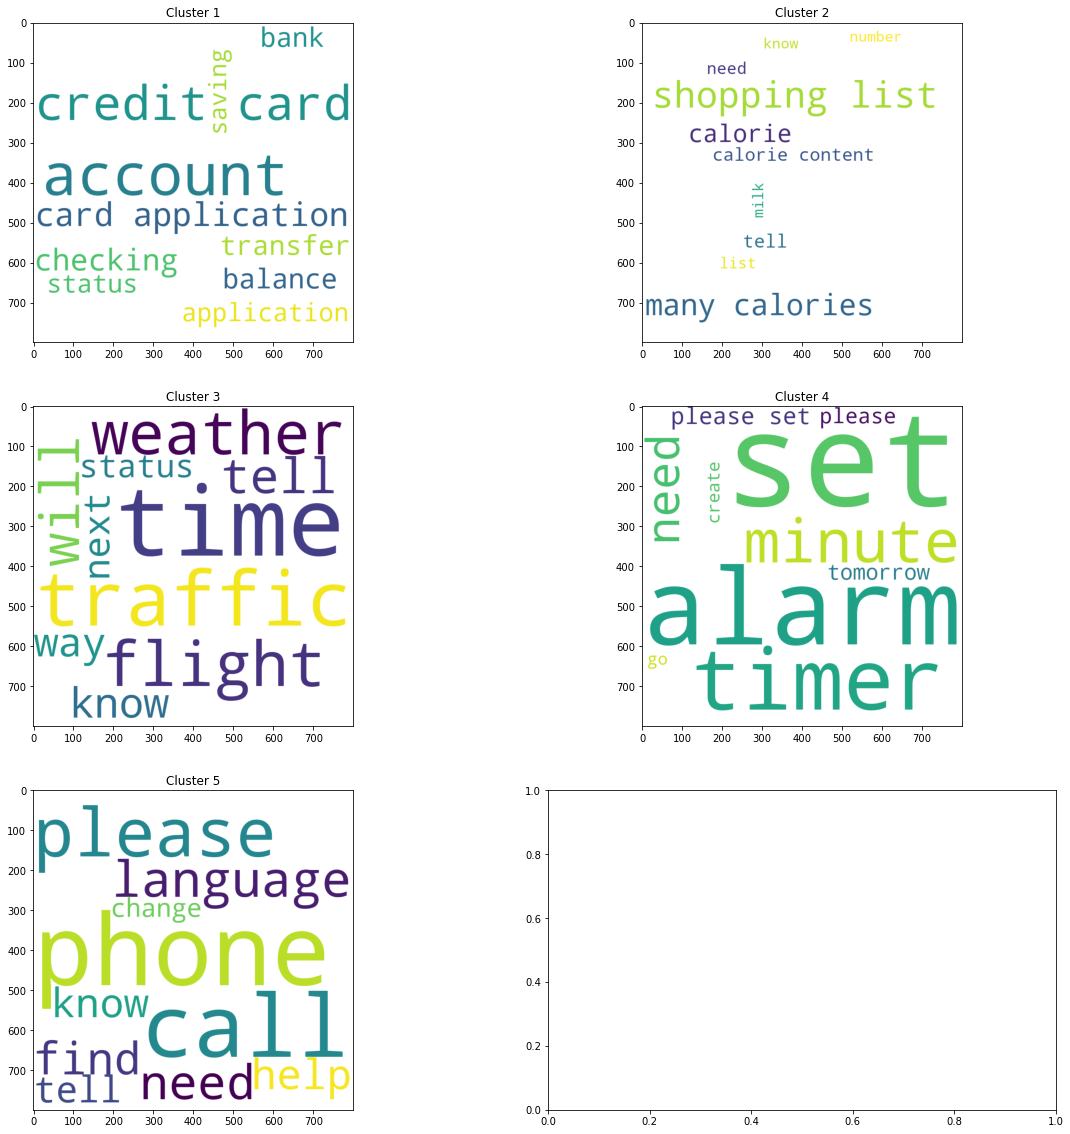

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(20,20))

ax_list = [ax1, ax2, ax3]
wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

ax1[0].set_title("Cluster 1")
ax1[1].set_title("Cluster 2")
ax2[0].set_title("Cluster 3")
ax2[1].set_title("Cluster 4")
ax3[0].set_title("Cluster 5")

ax1[0].imshow(wordcloud_list[0])
ax1[1].imshow(wordcloud_list[1])
ax2[0].imshow(wordcloud_list[2])
ax2[1].imshow(wordcloud_list[3])
ax3[0].imshow(wordcloud_list[4])

In [13]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.3199020423721346


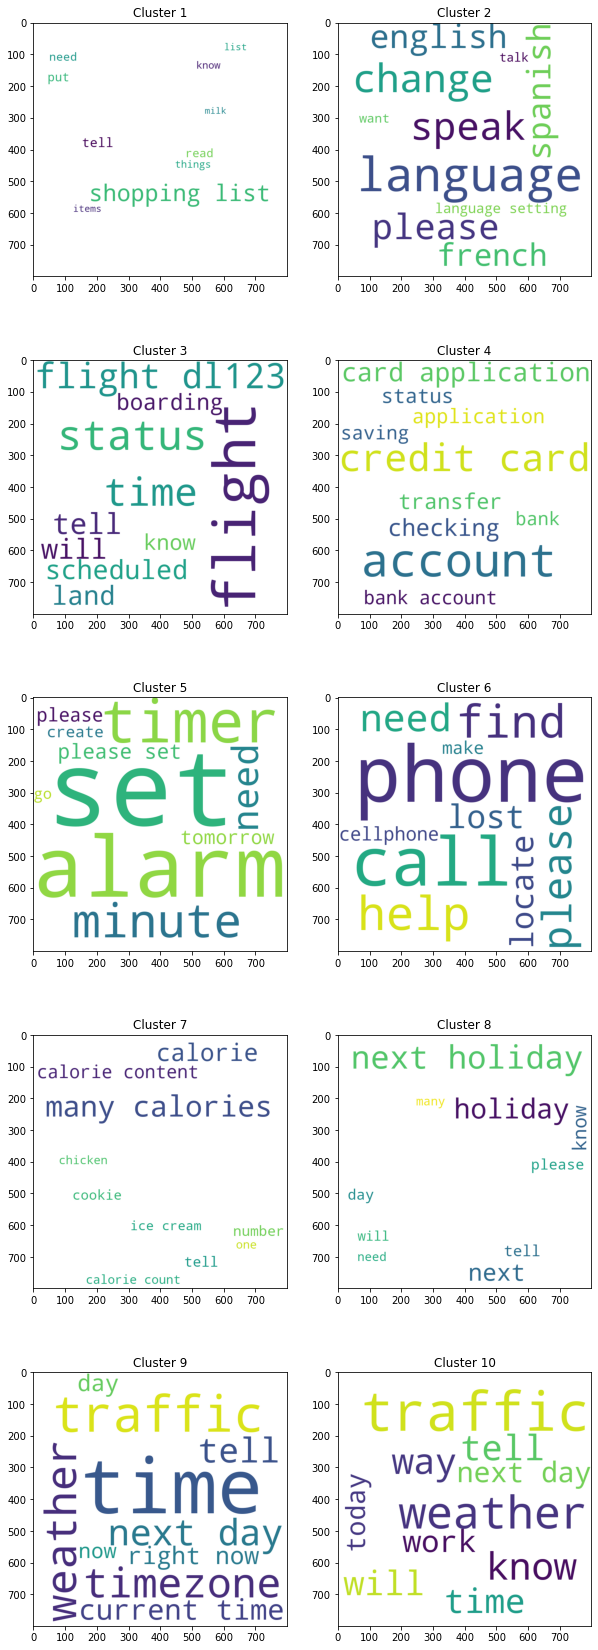

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize=(10 ,30))
wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

ax1[0].set_title("Cluster 1")
ax1[1].set_title("Cluster 2")
ax2[0].set_title("Cluster 3")
ax2[1].set_title("Cluster 4")
ax3[0].set_title("Cluster 5")
ax3[1].set_title("Cluster 6")
ax4[0].set_title("Cluster 7")
ax4[1].set_title("Cluster 8")
ax5[0].set_title("Cluster 9")
ax5[1].set_title("Cluster 10")

ax1[0].imshow(wordcloud_list[0])
ax1[1].imshow(wordcloud_list[1])
ax2[0].imshow(wordcloud_list[2])
ax2[1].imshow(wordcloud_list[3])
ax3[0].imshow(wordcloud_list[4])
ax3[1].imshow(wordcloud_list[5])
ax4[0].imshow(wordcloud_list[6])
ax4[1].imshow(wordcloud_list[7])
ax5[0].imshow(wordcloud_list[8])
ax5[1].imshow(wordcloud_list[9])

In [88]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.3446007655617193


### c. Remove stop words + Remove numeric and alphanumeric tokens

In [17]:
def _remove_stop_words_keep_alphabetic_tokens(sentence):
    tokens = sentence.split()
    new_tokens = []
    
    for token in tokens:
        if token in stop_words_dict:
            continue
        elif not token.isalpha():
            continue
        else:
            new_tokens.append(token)
            
    return " ".join(new_tokens)


In [18]:
utterance_vector_list = []

for index, row in utterances_data.iterrows():
    updated_sentence = _remove_stop_words_keep_alphabetic_tokens(row["utterance"])
    utterance_vector = spacy_medium_model(updated_sentence).vector
    utterance_vector_list.append(utterance_vector)

In [19]:
spacy_medium_utterance_vector_df = pd.DataFrame(utterance_vector_list)

# remove all the nan values from the df
spacy_medium_utterance_vector_df = spacy_medium_utterance_vector_df.dropna(how="all")

spacy_medium_utterance_vector_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.000193,-0.123207,-0.173320,0.044660,-0.174622,0.274310,-0.377301,-0.336219,0.027147,2.065867,...,-0.446097,0.235077,0.121358,0.104740,0.231737,-0.224013,0.092440,0.059983,-0.100873,0.148646
1,-0.111920,-0.083340,-0.217935,0.183895,-0.035294,0.102048,-0.231727,-0.171589,0.176363,1.780500,...,-0.581198,0.277011,0.031645,0.109622,0.284258,-0.317373,-0.096113,0.057401,0.143517,0.186047
2,-0.114956,0.114984,-0.317034,0.098086,-0.252429,0.185304,-0.149172,-0.224240,-0.062187,2.080800,...,-0.569134,0.327788,0.230994,-0.003600,0.402266,-0.320127,0.023907,0.097125,-0.041709,0.079360
3,-0.117971,-0.007441,-0.211333,0.067764,-0.094802,0.125383,-0.304491,-0.253646,0.001526,2.097234,...,-0.497683,0.174084,0.176190,0.024885,0.179109,-0.273640,0.116971,-0.001698,0.095443,0.068251
4,-0.159398,0.136512,-0.301292,0.139282,-0.239021,0.109036,-0.220659,-0.190514,-0.053528,2.239140,...,-0.555714,0.280379,0.205050,0.022999,0.283618,-0.364284,0.032916,-0.014026,0.001318,-0.044954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,-0.034511,0.142406,-0.076045,-0.169038,-0.347430,0.195750,0.255785,-0.156305,-0.098385,1.718950,...,-0.352385,0.465705,-0.064376,-0.060780,0.363360,-0.476825,-0.501345,0.000425,-0.210417,0.073737
2246,-0.004789,0.374390,-0.207165,-0.206445,-0.019480,0.186485,0.182125,0.159710,-0.198281,2.378900,...,-0.244710,0.272275,-0.250735,-0.160248,0.331720,-0.322605,-0.424230,0.058473,0.212533,0.051537
2247,-0.084311,0.417737,-0.173832,-0.105170,0.021784,-0.120931,0.073115,0.013163,-0.168329,2.483167,...,-0.275337,0.040247,-0.039220,-0.137000,0.168200,-0.376473,-0.204331,0.026930,0.062849,0.056905
2248,0.141238,0.173069,0.263020,0.102215,-0.190480,0.095840,0.000140,0.183595,-0.033345,2.199250,...,-0.147990,0.458210,0.011245,-0.214987,0.206380,-0.204490,-0.365450,-0.164570,-0.100182,-0.094973


In [20]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters, random_state=77)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.2433298251373051


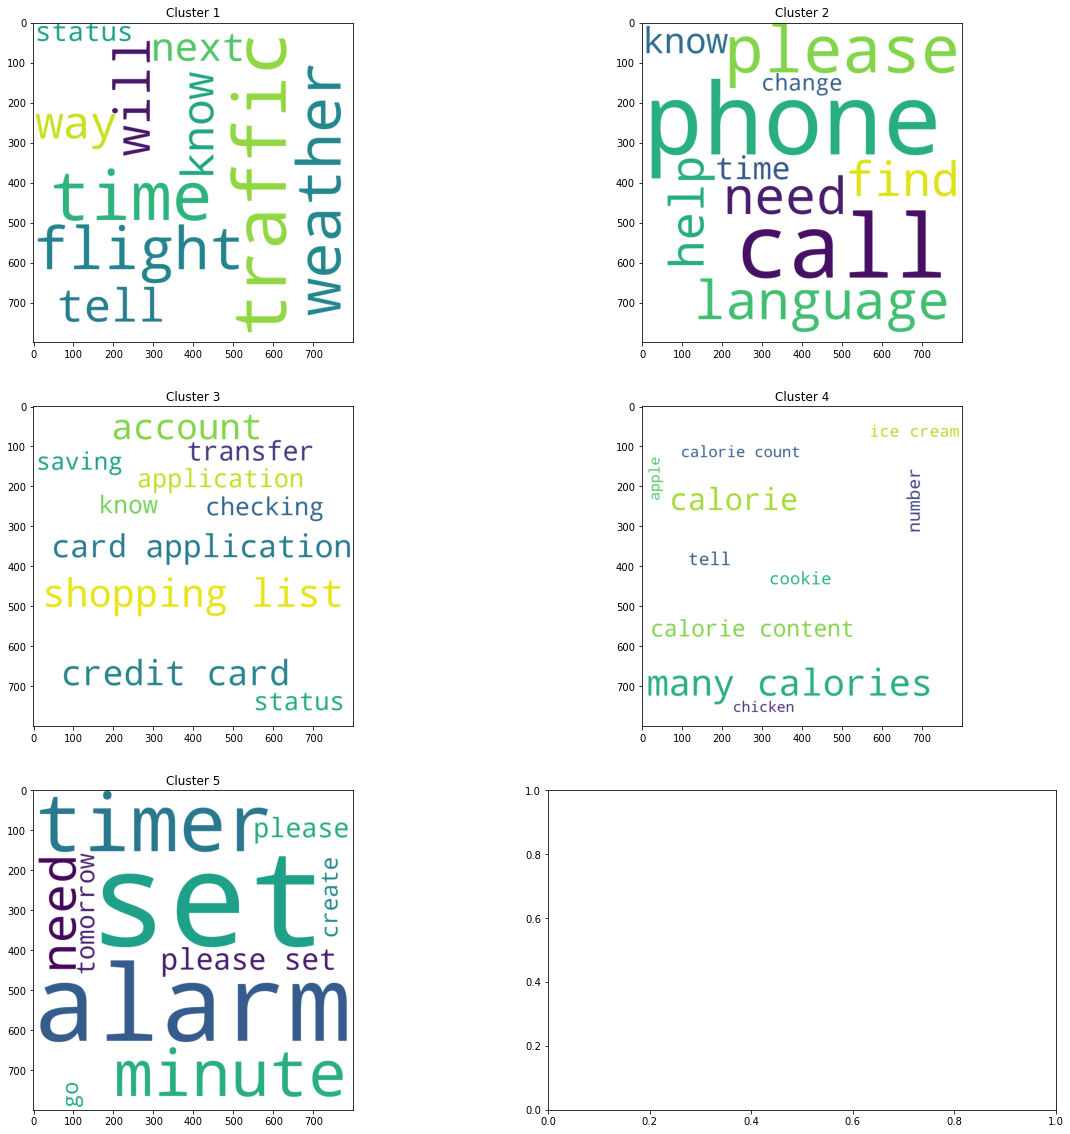

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(20,20))

ax_list = [ax1, ax2, ax3]
wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

ax1[0].set_title("Cluster 1")
ax1[1].set_title("Cluster 2")
ax2[0].set_title("Cluster 3")
ax2[1].set_title("Cluster 4")
ax3[0].set_title("Cluster 5")

ax1[0].imshow(wordcloud_list[0])
ax1[1].imshow(wordcloud_list[1])
ax2[0].imshow(wordcloud_list[2])
ax2[1].imshow(wordcloud_list[3])
ax3[0].imshow(wordcloud_list[4])

In [23]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters, random_state=7)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.3529024687609819


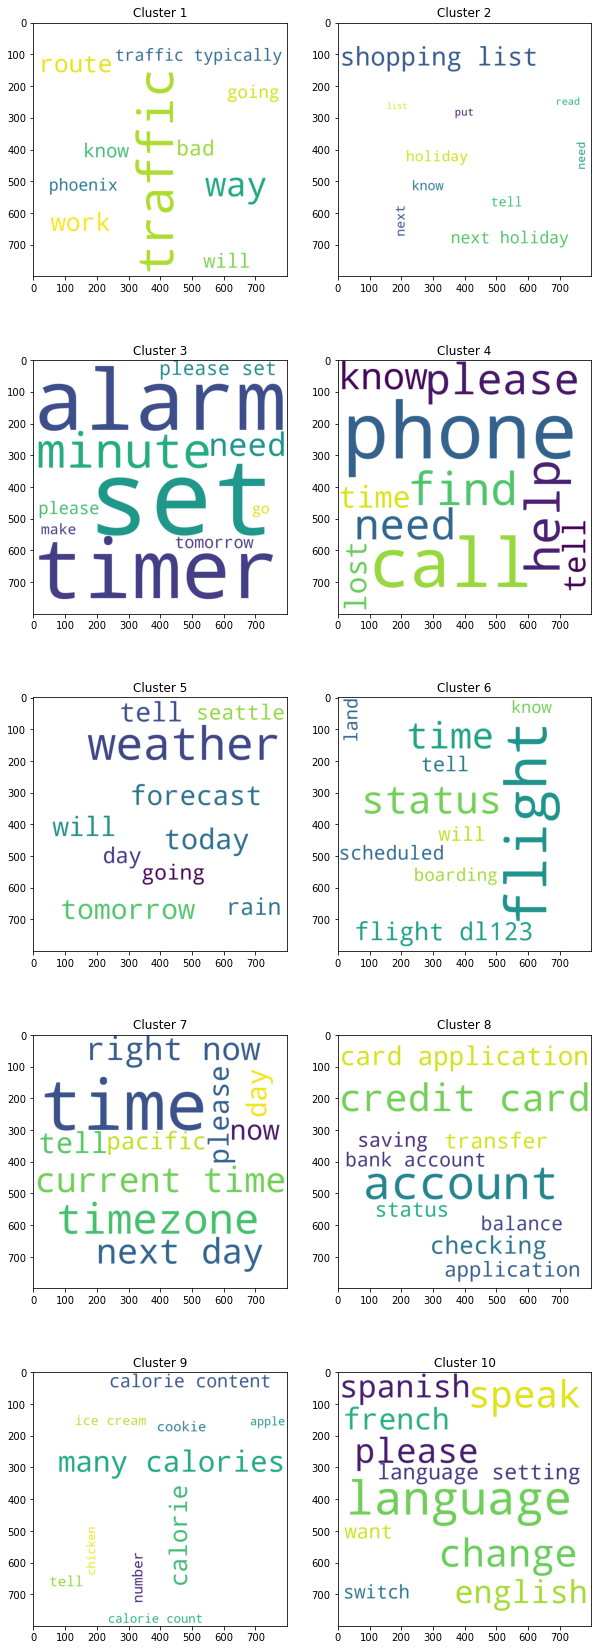

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize=(10 ,30))
wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

ax1[0].set_title("Cluster 1")
ax1[1].set_title("Cluster 2")
ax2[0].set_title("Cluster 3")
ax2[1].set_title("Cluster 4")
ax3[0].set_title("Cluster 5")
ax3[1].set_title("Cluster 6")
ax4[0].set_title("Cluster 7")
ax4[1].set_title("Cluster 8")
ax5[0].set_title("Cluster 9")
ax5[1].set_title("Cluster 10")

ax1[0].imshow(wordcloud_list[0])
ax1[1].imshow(wordcloud_list[1])
ax2[0].imshow(wordcloud_list[2])
ax2[1].imshow(wordcloud_list[3])
ax3[0].imshow(wordcloud_list[4])
ax3[1].imshow(wordcloud_list[5])
ax4[0].imshow(wordcloud_list[6])
ax4[1].imshow(wordcloud_list[7])
ax5[0].imshow(wordcloud_list[8])
ax5[1].imshow(wordcloud_list[9])

In [26]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters, random_state=19)
k_means_obj.fit(spacy_medium_utterance_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(spacy_medium_utterance_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.3784962739317951


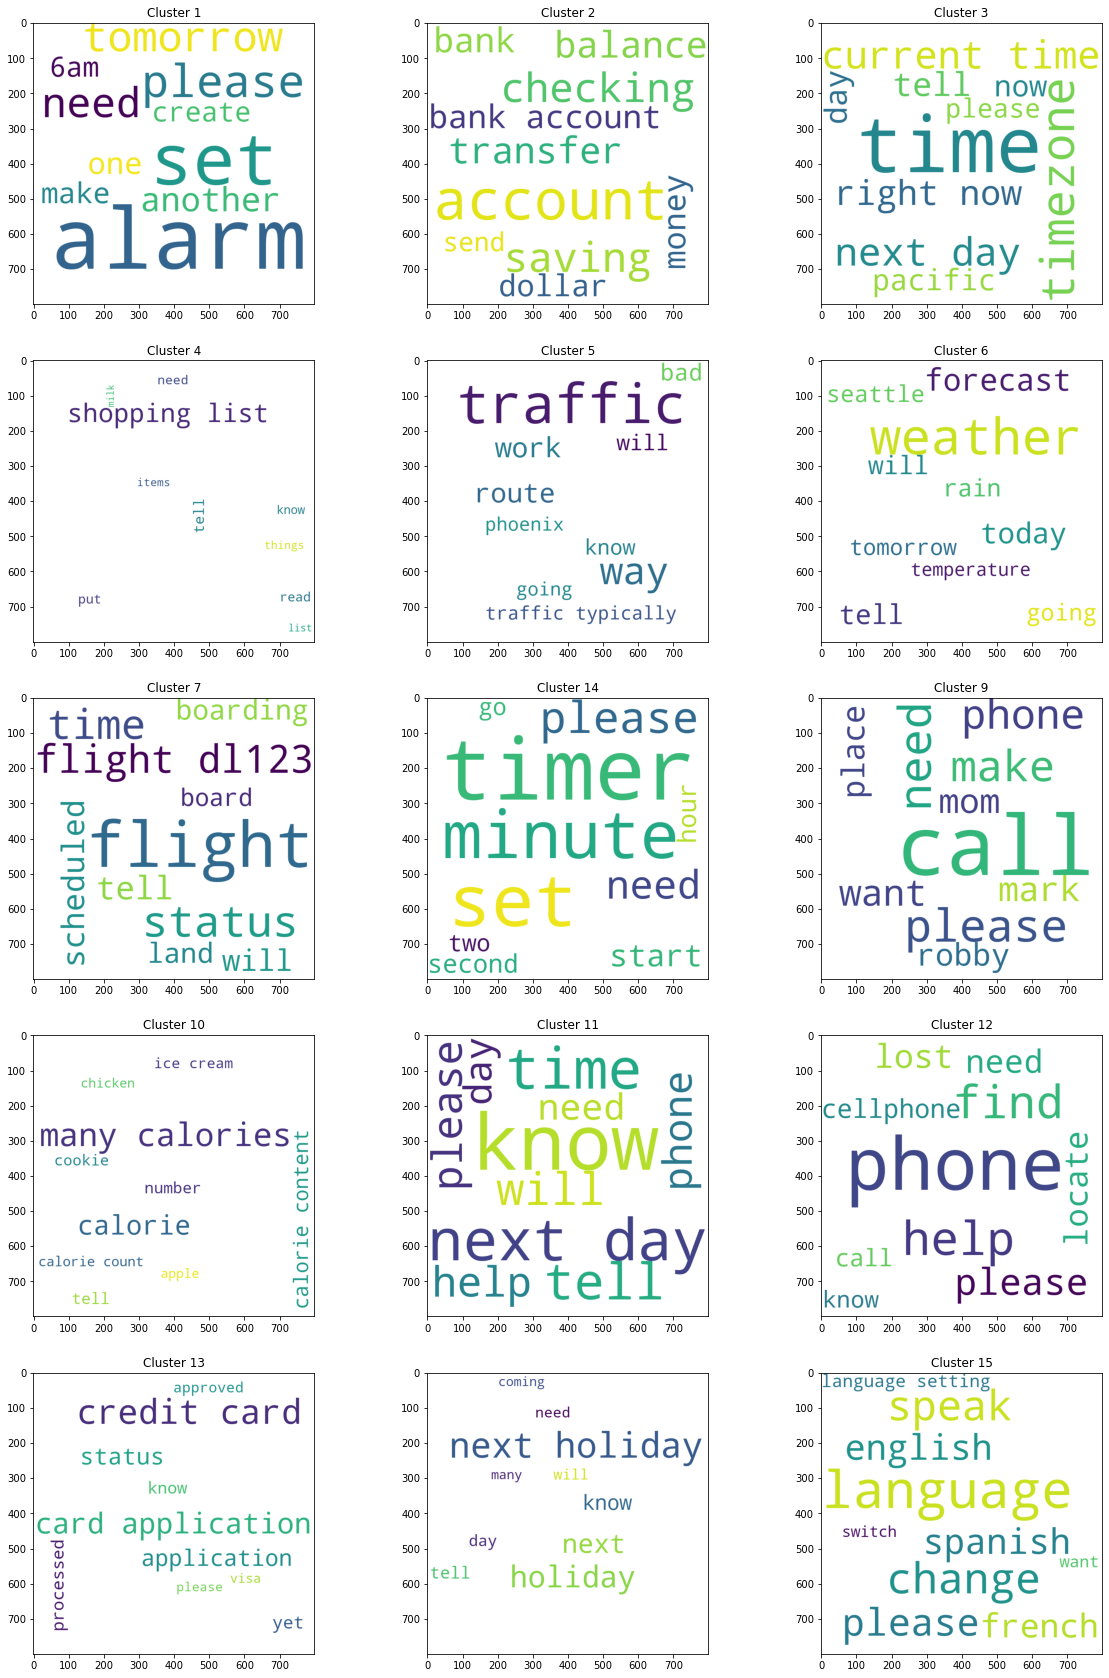

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 3, figsize=(20 ,30))
wordcloud_list = [create_word_cloud(i, cluster_indices_dict, utterances_data) for i in range(num_clusters)]

ax1[0].set_title("Cluster 1")
ax1[1].set_title("Cluster 2")
ax1[2].set_title("Cluster 3")
ax2[0].set_title("Cluster 4")
ax2[1].set_title("Cluster 5")
ax2[2].set_title("Cluster 6")
ax3[0].set_title("Cluster 7")
ax3[1].set_title("Cluster 8")
ax3[2].set_title("Cluster 9")
ax4[0].set_title("Cluster 10")
ax4[1].set_title("Cluster 11")
ax4[2].set_title("Cluster 12")
ax5[0].set_title("Cluster 13")
ax3[1].set_title("Cluster 14")
ax5[2].set_title("Cluster 15")

ax1[0].imshow(wordcloud_list[0])
ax1[1].imshow(wordcloud_list[1])
ax1[2].imshow(wordcloud_list[2])
ax2[0].imshow(wordcloud_list[3])
ax2[1].imshow(wordcloud_list[4])
ax2[2].imshow(wordcloud_list[5])
ax3[0].imshow(wordcloud_list[6])
ax3[1].imshow(wordcloud_list[7])
ax3[2].imshow(wordcloud_list[8])
ax4[0].imshow(wordcloud_list[9])
ax4[1].imshow(wordcloud_list[10])
ax4[2].imshow(wordcloud_list[11])
ax5[0].imshow(wordcloud_list[12])
ax5[1].imshow(wordcloud_list[13])
ax5[2].imshow(wordcloud_list[14])